In [1]:
import pyphen
import string
import re
import collections

import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Flatten
import keras

import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [9]:
%load_ext pep8_magic

In [2]:
hun_chars = 'aábcdeéfghiíjklmnoóöőpqrstuúüűvwxyz' + '^$'  # ^,$


def hyph_tags(word, hypher=pyphen.Pyphen(lang='hu_HU'), aslist=False):
    """Hyphenating classification of the characters in the word.
    {B(egin),M(iddle),E(nd),S(ingle)}"""
    if (len(word) == 0):
        raise IndexError("0 length word")
    ret = list('M' * len(word))
    ret[0] = 'B'
    ret[-1] = 'E'
    for i in hypher.positions(word):
        ret[i] = 'B'
        if(ret[i-1] == 'B'):
            ret[i-1] = 'S'
        else:
            ret[i-1] = 'E'
    if (aslist):
        return ret
    return "".join(ret)


def hyph_tags_4to2(word, aslist=False):
    """{B,M,E,S} to {B, M}"""
    ret = list(word)
    for i in range(len(ret)):
        if ret[i] == 'S':
            ret[i] = 'B'
        if ret[i] != 'B':
            ret[i] = 'M'
    if(aslist):
        return ret
    return "".join(ret)


def same_char_num(word, hypher=pyphen.Pyphen(lang='hu_HU')):
    """Return true if the hyphenated word has as many chars as the original"""
    return len(hypher.inserted(word)) == len(word)+len(hypher.positions(word))


def cleaning(data):
    """Text cleaning:
        lower the letters
        punctuation, digits ellimination"""
    formated_data = data.lower()
    formated_data = re.sub('['+string.punctuation+']', '', formated_data)
    formated_data = re.sub('['+string.digits+']', '', formated_data)
    return formated_data


# onehot: {'B','M','E','S'}
def one_hot_encode(char, dictionary='BMES'):
    ret = [0]*len(dictionary)
    if char in dictionary:
        ret[dictionary.find(char)] = 1
        return ret
    raise ValueError('Value out of dictionary range: '+char)


def unison_shuffled_copies(a, b):
    """Randomize 2 same length array in the same permutation"""
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def one_hot_decode(arr, dictionary='BMES'):
    assert len(arr) == len(dictionary)
    i = np.nonzero(arr)[0][0]
    return dictionary[i]


def generate_network_data(data, ret_input=[], ret_output=[],
                          length=2, length_after=0,
                          start_char='^', end_char='$',
                          chars=hun_chars, tag_chars='BMES'):
    """from [word,hyph_class(word) to length-long input-output data"""
    word = data[0]
    word_plus = start_char*(length-length_after-1)+word+end_char*length_after
    hyph_word = data[1]
    for i in range(0, len(word)):
        input_next_iter = []
        for c in word_plus[i:i+length]:
            input_next_iter.append(one_hot_encode(c, chars))
        output_next_iter = one_hot_encode(hyph_word[i], tag_chars)
        ret_input.append(input_next_iter)
        ret_output.append(output_next_iter)
    return

def hyph_tupples(data, hypher=pyphen.Pyphen(lang='hu_HU'),
                tag_chars='BM'):
    """[words] -> [words, hyph_words]"""
    word_list = []
    c_all = 0
    c_same_char_num = 0
    for next_word in data:
        c_all += 1
        if(len(next_word) != 0 and same_char_num(next_word, hypher)):
            c_same_char_num += 1
            if(len(tag_chars) == 2):
                word_list.append([next_word,
                                  hyph_tags_4to2(hyph_tags(next_word))])
            else:
                word_list.append([next_word, hyph_tags(next_word)])
    return word_list, c_all, c_same_char_num

def tupple_to_train(word_list, window_length, length_after,
                 tag_chars='BM'):
    """[words, hyph_words] -> in[0,1,0...], out[0,1,0...]"""
    data_in = []
    data_out = []
    wrong_word = 0
    for word in word_list:
        try:
            generate_network_data(word, data_in, data_out,
                                  window_length, tag_chars=tag_chars,
                                  length_after=length_after)
        except ValueError:
            wrong_word += 1
    return data_in, data_out, wrong_word

# Data import

In [3]:
def data_reader(file, tail_cut=100000):
    """Read data from file"""

    tail_cut_ptest_words = tail_cut + 500

    counter_hu_data = collections.Counter()
    with open('web2.2-freq-sorted.txt', 'r',
              errors='ignore', encoding='latin2') as f:
        i = 0
        for line in f:
            i = i+1
            words = line.split()
            if len(words) > 1:
                if(words[1].isdigit()):
                    counter_hu_data[cleaning(words[0])] += int(words[1])
            if i > tail_cut_ptest_words:
                break
    return counter_hu_data

In [98]:
def train_data_generator(data_counter, window_length, length_after,
                         tag_chars='BM', tail_cut=100000,
                         valid_rate=0.2, test_rate=0.1):
    """Generate training data from counter data
    unique words -> characters -> randomize -> cut"""

    data_list = np.array(counter_hu_data.most_common(tail_cut))[:,0]
    word_list, c_all, c_same_char_num = hyph_tupples(data_list,
                                                    tag_chars=tag_chars)
    print('Data read successfully')
    print(c_same_char_num, c_all, c_same_char_num/c_all)

    # Generate network data
    data_in = []
    data_out = []
    wrong_word = 0
    data_in, data_out, wrong_word = tupple_to_train(word_list,
                                                    window_length,
                                                    length_after,
                                                    tag_chars=tag_chars)
    print('Data len: ', len(data_in))
    print('Wrong words: ', wrong_word)

    data_len = len(data_in)

    data_in = np.array(data_in, dtype='float32')
    data_out = np.array(data_out, dtype='float32')
    data_in, data_out = unison_shuffled_copies(data_in, data_out)
    tests_input = data_in[0:int(data_len*test_rate)]
    tests_target = data_out[0:int(data_len*test_rate)]
    valid_input = data_in[int(data_len*test_rate):
                          int(data_len*(test_rate+valid_rate))]
    valid_target = data_out[int(data_len*test_rate):
                            int(data_len*(test_rate+valid_rate))]
    train_input = data_in[int(data_len*(test_rate+valid_rate)):]
    train_target = data_out[int(data_len*(test_rate+valid_rate)):]

    print('Training data size:', np.shape(train_input), np.shape(train_target))
    print('Validation data size:', np.shape(valid_input),
          np.shape(valid_target))
    print('Test data size:', np.shape(tests_input), np.shape(tests_target))

    train_input_flatten = np.reshape(
        train_input, (len(train_input), (window_length)*len(hun_chars)))
    valid_input_flatten = np.reshape(
        valid_input, (len(valid_input), (window_length)*len(hun_chars)))
    tests_input_flatten = np.reshape(
        tests_input, (len(tests_input), (window_length)*len(hun_chars)))
    print('Network data generated successfully')

    return [train_input_flatten, train_target,
            valid_input_flatten, valid_target,
            tests_input_flatten, tests_target]


def train_data_generator_uwords(data_counter, window_length, length_after,
                                tag_chars='BM', tail_cut=100000,
                                valid_rate=0.2, test_rate=0.1):
    """Generate training data from counter data
        unique words -> randomize -> cut -> characters"""
    data_list = np.array(counter_hu_data.most_common(tail_cut))[:,0]
    np.random.shuffle(data_list)
    data_len = len(data_list)
    tests_data = data_list[0:int(data_len*test_rate)]
    valid_data = data_list[int(data_len*test_rate):
                           int(data_len*(test_rate+valid_rate))]
    train_data = data_list[int(data_len*(test_rate+valid_rate)):]
    
    c_all = 0
    c_same_char_num = 0
    tests_list, c_all_p, c_same_char_num_p = hyph_tupples(tests_data,
                                                          tag_chars=tag_chars)
    c_all += c_all_p
    c_same_char_num += c_same_char_num_p
    valid_list, c_all_p, c_same_char_num_p = hyph_tupples(valid_data,
                                                          tag_chars=tag_chars)
    c_all += c_all_p
    c_same_char_num += c_same_char_num_p
    train_list, c_all_p, c_same_char_num_p = hyph_tupples(train_data,
                                                          tag_chars=tag_chars)
    c_all += c_all_p
    c_same_char_num += c_same_char_num_p
    
    print('Data read successfully')
    print(c_same_char_num, c_all, c_same_char_num/c_all)
    
    wrong_word = 0
    tests_input, tests_target, wrong_w_p = tupple_to_train(tests_list,
                                                           window_length,
                                                           length_after,
                                                           tag_chars=tag_chars)
    wrong_word += wrong_w_p
    valid_input, valid_target, wrong_w_p = tupple_to_train(valid_list,
                                                           window_length,
                                                           length_after,
                                                           tag_chars=tag_chars)
    wrong_word += wrong_w_p
    train_input, train_target, wrong_w_p = tupple_to_train(train_list,
                                                           window_length,
                                                           length_after,
                                                           tag_chars=tag_chars)
    wrong_word += wrong_w_p
    print('Wrong words: ', wrong_word)

    print('Training data size:', np.shape(train_input), np.shape(train_target))
    print('Validation data size:', np.shape(valid_input),
          np.shape(valid_target))
    print('Test data size:', np.shape(tests_input), np.shape(tests_target))

    train_input_flatten = np.reshape(
        train_input, (len(train_input), (window_length)*len(hun_chars)))
    valid_input_flatten = np.reshape(
        valid_input, (len(valid_input), (window_length)*len(hun_chars)))
    tests_input_flatten = np.reshape(
        tests_input, (len(tests_input), (window_length)*len(hun_chars)))
    print('Network data generated successfully')

    return [train_input_flatten, train_target,
            valid_input_flatten, valid_target,
            tests_input_flatten, tests_target]
    

def train_data_generator_uchars(data_counter, window_length, length_after,
                                tag_chars='BM', tail_cut=100000,
                                valid_rate=0.2, test_rate=0.1):
    """Generate training data from counter data
        unique words -> characters -> unique -> randomize -> cut"""
    data_list = np.array(counter_hu_data.most_common(tail_cut))[:,0]
    word_list, c_all, c_same_char_num = hyph_tupples(data_list,
                                                    tag_chars=tag_chars)
    print('Data read successfully')
    print(c_same_char_num, c_all, c_same_char_num/c_all)

    # Generate network data
    data_in = []
    data_out = []
    wrong_word = 0
    data_in, data_out, wrong_word = tupple_to_train(word_list,
                                                    window_length,
                                                    length_after,
                                                    tag_chars=tag_chars)
    print('Data len: ', len(data_in))
    print('Wrong words: ', wrong_word)

    #Unique
    data_len = len(data_in)

    data_in = np.array(data_in, dtype='float32')
    data_out = np.array(data_out, dtype='float32')
    
    shape_in = np.shape(data_in)
    shape_out = np.shape(data_out)
    
    data_in_flatten = np.reshape(
        data_in, (shape_in[0], shape_in[1]*shape_in[2]))
    shape_in_flatten = np.shape(data_in_flatten)
    
    data_iosum = np.concatenate((data_in_flatten, data_out), axis=1)
    data_iosum_unique = np.vstack({tuple(row) for row in data_iosum})
    
    data_in = data_iosum_unique[:,:-shape_out[1]]
    data_out = data_iosum_unique[:,-shape_out[1]:]
    print('Data unique len: ', np.shape(data_iosum_unique)[0])
    
    data_len = len(data_in)
    data_in, data_out = unison_shuffled_copies(data_in, data_out)
    tests_input = data_in[0:int(data_len*test_rate)]
    tests_target = data_out[0:int(data_len*test_rate)]
    valid_input = data_in[int(data_len*test_rate):
                          int(data_len*(test_rate+valid_rate))]
    valid_target = data_out[int(data_len*test_rate):
                            int(data_len*(test_rate+valid_rate))]
    train_input = data_in[int(data_len*(test_rate+valid_rate)):]
    train_target = data_out[int(data_len*(test_rate+valid_rate)):]

    print('Training data size:', np.shape(train_input), np.shape(train_target))
    print('Validation data size:', np.shape(valid_input),
          np.shape(valid_target))
    print('Test data size:', np.shape(tests_input), np.shape(tests_target))

    train_input_flatten = np.reshape(
        train_input, (len(train_input), (window_length)*len(hun_chars)))
    valid_input_flatten = np.reshape(
        valid_input, (len(valid_input), (window_length)*len(hun_chars)))
    tests_input_flatten = np.reshape(
        tests_input, (len(tests_input), (window_length)*len(hun_chars)))
    print('Network data generated successfully')

    return [train_input_flatten, train_target,
            valid_input_flatten, valid_target,
            tests_input_flatten, tests_target]
    

# DNN Model

In [5]:
def model_creator(window_length, output_length, num_layers=1,
                  num_hidden=10, chars=hun_chars):
    """Creates Keras model with the given input, output dimensions
    and layer number, hidden layer length"""
    model = Sequential()
    model.add(Dense(input_dim=((window_length)*len(chars)),
                    units=num_hidden, name='input_layer',
                    activation='sigmoid'))
    for i in range(1, num_layers):
        model.add(Dense(units=num_hidden, activation='sigmoid'))

    # model.add(Flatten())
    model.add(Dense(output_length, name='output_layer', activation='softmax'))

    if(output_length == 2):
        model.compile(loss='binary_crossentropy', optimizer='adam')
    else:
        model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# Main

In [99]:
tail_cut = 100#000
window_length = 7
length_after = 3
tag_chars = 'BM'
num_layers = 5
num_hidden = 110

# Data read and network data generate
counter_hu_data = data_reader('web2.2-freq-sorted.txt')
[train_input_flatten, train_target,
 valid_input_flatten, valid_target,
 tests_input_flatten,
 tests_target] = train_data_generator_uchars(counter_hu_data,
                                             window_length,
                                             length_after,
                                             tag_chars,
                                             tail_cut)

# Creating the keras model
model = model_creator(window_length, len(tag_chars),
                      num_layers, num_hidden)
print('Model created. Start training...')

earlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0, mode='auto')

Data read successfully
99 100 0.99
Data len:  358
Wrong words:  0
Data unique len:  354
Training data size: (248, 259) (248, 2)
Validation data size: (71, 259) (71, 2)
Test data size: (35, 259) (35, 2)
Network data generated successfully
Model created. Start training...


In [47]:
history = model.fit(train_input_flatten, train_target,
                    epochs=10, batch_size=1024,
                    validation_data=(valid_input_flatten, valid_target),
                    verbose=0, callbacks=[earlyStopping])

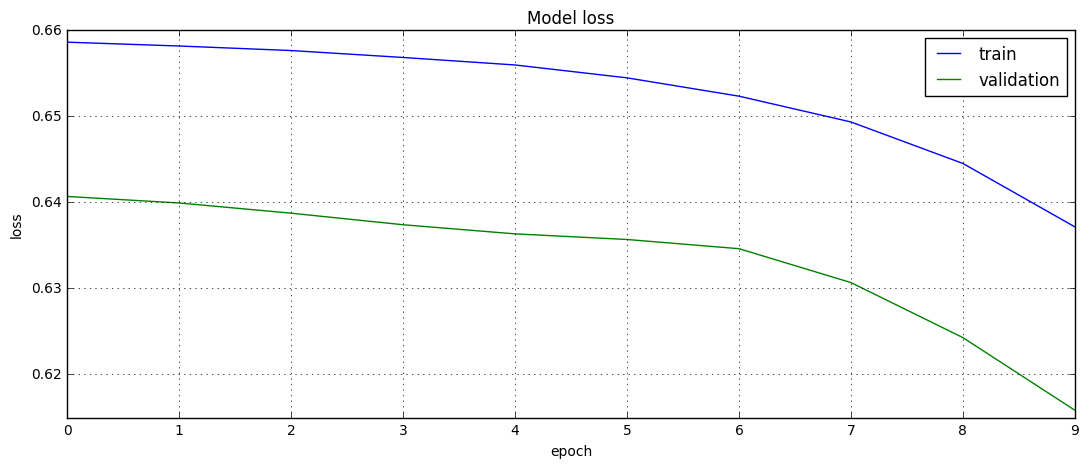

In [48]:
# summarize history for loss
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.ylim((0.04, 0.06))
plt.grid()
plt.show()

# Evaluation

In [97]:
test_results = model.predict(tests_input_flatten)
test_tp = 0
test_fp = 0
test_tn = 0
test_fn = 0
test_str = ""
if(np.shape(test_results)[1] == 2):
    for i in range(len(test_results)):
        # positive
        if np.argmax(test_results[i]) == 1:
            if np.argmax(tests_target[i]) == 1:
                test_tn += 1
            else:
                test_fn += 1
        else:
            if np.argmax(tests_target[i]) == 1:
                test_fp += 1
            else:
                test_tp += 1
    print(np.shape(test_results),np.shape(tests_target))
    print(test_tp,test_fp,test_tn,test_fn)
    test_precision = test_tp / (test_tp + test_fp)
    test_recall = test_tp / (test_tp + test_fn)
    test_Fscore = 2 * (test_precision * 
                       test_recall) / (test_precision + test_recall)
    test_str = str(test_precision) + '\t' + str(test_recall) 
    test_str += '\t' + str(test_Fscore)
else:
    for i in range(len(test_results)):
        if np.argmax(test_results[i]) == np.argmax(tests_target[i]):
            test_success += 1
        else:
            test_fail += 1
    test_str = str(test_fail/(test_fail+test_success))

with open("results_prf.txt", "a") as myfile:
    result = ""
    result += str(window_length) + '\t'
    result += str(length_after) + '\t' + tag_chars
    result += '\t' + str(num_layers) + '\t'
    result += str(num_hidden) + '\t'
    result += str(history.epoch[-1]) + '\t'
    result += str(history.history['val_loss'][-1])
    result += '\t' + test_str
    result += '\n'
    myfile.write(result)

(529, 2) (529, 2)
189 340 0 0


## Words

In [13]:
def hpyh_predict(word, model,
                 length=2, length_after=0, tag_chars='BMES', aslist=False):
    """Generate tagging from the input word according to the model"""
    word_in = []
    word_out = []
    generate_network_data([word, len(word)*tag_chars[0]],
                          word_in, word_out, length=length,
                          length_after=length_after, tag_chars=tag_chars)
    word_in = np.reshape(word_in, (len(word_in), (length)*len(hun_chars)))
    word_out = model.predict(word_in)
    tag_list = np.array(list(tag_chars))
    temp = np.argmax(word_out, axis=1)
    temp = tag_list[temp]
    if(aslist):
        return temp
    return "".join(temp)

In [18]:
hypher = pyphen.Pyphen(lang='hu_HU')

In [25]:
test = 'szemüveg'
print('Word:', test, 'Prediction:',
      hpyh_predict(test, model, window_length, length_after, tag_chars),
      'Target:', hyph_tags_4to2(hyph_tags(test)), hypher.inserted(test))

test = 'leopárd'
print('Word:', test, 'Prediction:',
      hpyh_predict(test, model, window_length, length_after, tag_chars),
      'Target:', hyph_tags_4to2(hyph_tags(test)), hypher.inserted(test))

Word: szemüveg Prediction: BMMBMBMM Target: BMMMBMMM szem-üveg
Word: leopárd Prediction: BMBBMMM Target: BMBBMMM le-o-párd


In [26]:
test_words = counter_hu_data.most_common()[-500:]
print('Word\tSuccess\tPrediction\tTarget\tVisualization')
for word in test_words:
    next_word = word[0]
    if(len(next_word) != 0 and same_char_num(next_word)):
        try:
            predicted_value = hpyh_predict(next_word, model,
                                           window_length, length_after,
                                           tag_chars)
            excepted_value = hyph_tags_4to2(hyph_tags(next_word))
            success = predicted_value == excepted_value
            if not success:
                print(next_word, '\t', success, '\t', predicted_value,
                      '\t', excepted_value, '\t', hypher.inserted(next_word))
        except ValueError as e:
            print(str(e))

Word	Success	Prediction	Target	Visualization
Value out of dictionary range: ŕ
szabadidőt 	 False 	 BMMBMBMBMM 	 BMMBMMBMMM 	 sza-bad-időt
közigazgatásilag 	 False 	 BMBBBMMBMBMBMBMM 	 BMMBMMMBMBMBMBMM 	 köz-igaz-ga-tá-si-lag
oleg 	 False 	 BMMM 	 BMBM 	 ol-eg
rózsafüzér 	 False 	 BMBMMBMMMM 	 BMBMMBMBMM 	 ró-zsa-fü-zér
táncszínház 	 False 	 BMMMMMMMBMM 	 BMMMBMMMBMM 	 tánc-szín-ház
együttérzést 	 False 	 BMMMMBMMBMMM 	 BMMMMMBMBMMM 	 együtt-ér-zést
geboren 	 False 	 BMBMBMM 	 BMBMMMM 	 ge-boren
felosztva 	 False 	 BMBMMMMBM 	 BMMBMMMBM 	 fel-oszt-va
beizzik 	 False 	 BMMMBMM 	 BMBMBMM 	 be-iz-zik
integratív 	 False 	 BMBMMBMBMM 	 BMBMBMMBMM 	 in-te-gra-tív
Value out of dictionary range: ô
jogegyenlőség 	 False 	 BMBBMMMMBMBMM 	 BMMBMMMMBMBMM 	 jog-egyen-lő-ség
információforrások 	 False 	 BMBMMBMBMBBMMBMBMM 	 BMBMMBMBMMBMMBMBMM 	 in-for-má-ció-for-rá-sok
perspektívából 	 False 	 BMMBBMMBMBMBMM 	 BMMMBMMBMBMBMM 	 pers-pek-tí-vá-ból
kialakít 	 False 	 BMBBMBMM 	 BMBMMBMM 	 ki-ala-kít
que

# Sandbox

In [18]:
counter_hu_data = data_reader('web2.2-freq-sorted.txt')
hypher = pyphen.Pyphen(lang='hu_HU')

In [19]:
np.array(counter_hu_data.most_common(100))[:,0]

array(['a', '', 'az', 'és', 'hogy', 'nem', 'is', 'egy', 'the', 'meg', 'de',
       'ha', 'csak', 'ez', 'van', 'vagy', 'már', 'volt', 'of', 'még',
       'kell', 'azt', 'el', 'mint', 'and', 'ki', 'in', 'akkor', 'minden',
       'to', 'lehet', 'mert', 's', 'be', 'sem', 'én', 'olyan', 'ezt', 'e',
       'magyar', 'így', 'új', 'szerint', 'nagy', 'most', 'úgy', 'jó',
       'pedig', 'itt', 'nagyon', 'két', 'majd', 'aki', 'után', 'fel',
       'több', 'mi', 'ami', 'lesz', 'első', 'nincs', 'között', 'amely',
       'for', 'más', 'hanem', 'amikor', 'ilyen', 'kft', 'illetve', 'ne',
       'amit', 'arra', 'egyik', 'es', 'alatt', 'sok', 'volna', 'i', 'le',
       'azonban', 'azért', 'való', 'ennek', 'ő', 'által', 'ott', 'mit',
       'saját', 'jól', 'kis', 'számára', 'valamint', 'akik', 'ezért',
       'annak', 'igen', 'mindig', 'on', 'as'], 
      dtype='<U9')

In [9]:
for i in hypher.iterate('almáspite'):
    print(i)

('almáspi', 'te')
('almás', 'pite')
('al', 'máspite')


In [63]:
def part_hyph(word):
    pos = hypher.positions(word)
    if len(pos)<1:
        return
    if len(pos)+2==len(re.findall('[aáeéiíoóöőuúüű]',word)):
        return
    hyphs = []
    hyphs.append(word[:pos[0]])
    for i in range(len(pos)-1):
        hyphs.append(word[pos[i]:pos[i+1]])
    hyphs.append(word[pos[-1]:])
    for part in hyphs:
        mgh = len(re.findall('[aáeéiíoóöőuúüű]',part))
        if(mgh>1):
            part_hyph = hypher.inserted(part)
            if len(part)<len(part_hyph):
                print(hypher.inserted(word), part_hyph)

In [64]:
for word in np.array(counter_hu_data.most_common(100000))[:,0]:
    part_hyph(word)

euro-pe-an eu-ro
euro-pe eu-ro
emo-tiko-nok ti-ko
re-g-istra-ti-on ist-ra
home-page ho-me
shakes-peare sha-kes
mail-to-maisersz-ec-he-nyink-zsa-su-li-net-hu maiser-sz
open-of-fice-org fi-ce
shakes-pearei sha-kes
note-book no-te
http-ha-ku-son-e-rapla-zaf rap-la
provi-sions pr-ovi
moun-tain ta-in
httpwww-ma-levo-le-comm le-vo
li-baudio-fi-le bau-dio
ad-mi-nistra-tive nist-ra
eins-tein te-in
ch-ris-tina ti-na
moun-tains ta-ins
open-of-fice fi-ce
égale-ment ég-ale
witt-gen-s-tein te-in
share-ware sha-re
an-nakide-jén na-ki-de
mailt-ran-spor-tagent tag-ent
aut-hori-za-ti-on ho-ri
at-lan-tióce-án tió-ce
over-come co-me
geor-gia-pa-ci-fic ge-or
his-toris-c-hen to-ris
note-boo-kok no-te
geor-gia ge-or
con-centra-tions cent-ra
note-boo no-te
mar-seille se-ille
note-boo-kom no-te
disap-peared di-sap
sour-ce-for-geon ge-on
or-gapache-ca-ta-li-na-co-restan-dard-pi-pe-line res-tan
exa-mining mi-ning
eva-luat-ing lu-at
disap-pear di-sap
alias-es ali-as
cor-pora-tions po-ra
ch-ipse-tes ip-se
itali-e

In [54]:
len(re.findall('[aáeéiíoóöőuúüű]','üveg'))

2

In [3]:
def bigram_counter_from_file(filename):
    """creates bigram counter from file"""
    with open(filename) as f:
        word_list = []
        for words in f:
            words = words.strip()
            words = words.split()
            for w in words:
                w = cleaning(w)
                if len(w)>0:
                    word_list.append(w)
    word_list = np.unique(word_list)

    bigram_counter = collections.Counter()
    for word in word_list:
        for i in range(2,len(word)):
            bigram_counter[word[i-2:i]] += 1
    return bigram_counter
def bigrams_in_word(word, bigram_counter, mc=100):
    bigrams = np.array(bigram_counter.most_common(mc))[:,0]
    w_bc = len(word)-1
    if w_bc<1:
        return 1.0
    w_bf = 0
    for i in range(2,len(word)):
        if word[i-2:i] in bigrams:
            w_bf +=1
    return w_bf/w_bc

In [4]:
bigram_counter_en = bigram_counter_from_file('../wikipedia/angol/ossz_angol')
bigram_counter_hu = bigram_counter_from_file('../wikipedia/magyar/ossz_magyar')
print(len(bigram_counter_en.most_common()))
print(len(bigram_counter_hu.most_common()))

504
803


In [5]:
test_word = 'kabátgomb'
print(bigrams_in_word(test_word, bigram_counter_en))
print(bigrams_in_word(test_word, bigram_counter_hu))

0.125
0.375


In [14]:
words = ['almáspite', 'narancshéj', 'kitűző', 'cipőfűző', 'hintaló',
         'kabátgomb', 'száj', 'zenedoboz', 'égimeszelő', 'szentjánosbogár',
         'hyphenation', 'diary', 'integrity', 'spelling', 'backpropagation',
         'intermediate', 'holdings', 'learn', 'interesting', 'guest']

In [17]:
threshold = 0.2
for w in words:
    hu_like = bigrams_in_word(w, bigram_counter_hu)
    en_like = bigrams_in_word(w, bigram_counter_en)
    if (hu_like-en_like)>threshold:
        print('hu')
    else: 
        if (en_like-hu_like)>threshold:
            print('en')
        else:
            print('idk')

idk
idk
idk
idk
idk
hu
hu
hu
hu
hu
idk
en
idk
en
en
idk
en
en
en
idk
